In [1]:
import numpy as np
import pandas as pd

import os
# Age,Sex,Group,Duration_(sec),MLU_Utts,MLU_Morphemes,FREQ_TTR,Words_Min,Verbs_Utt,%_Word_Errors,Utt_Errors,density,%_Nouns,%_Plurals,%_Verbs,%_Aux,%_Mod,%_3S,%_13S,%_PAST,%_PASTP,%_PRESP,%_prep,%_adj,%_adv,%_conj,%_det,%_pro,noun_verb,retracing,repetition,mor_Utts,mor_syllables,syllables_min,%_Prolongation,Mean_RU,%_Phonological_fragment,%_Phrase_repetitions,%_Word_revisions,%_Phrase_revisions,%_Pauses,%_Filled_pauses,%_TD,SLD_Ratio,Content_words_ratio,Function_words_ratio,N,V,Q,S

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv("train2.csv")

In [4]:
df.head()

,Age,Sex,Group,Duration_(sec),MLU_Utts,MLU_Morphemes,FREQ_TTR,Words_Min,Verbs_Utt,%_Word_Errors,Utt_Errors,density,%_Nouns,%_Plurals,%_Verbs,%_Aux,%_Mod,%_3S,%_13S,%_PAST,%_PASTP,%_PRESP,%_prep,%_adj,%_adv,%_conj,%_det,%_pro,noun_verb,retracing,repetition,mor_Utts,mor_syllables,syllables_min,%_Prolongation,Mean_RU,%_Phonological_fragment,%_Phrase_repetitions,%_Word_revisions,%_Phrase_revisions,%_Pauses,%_Filled_pauses,%_TD,SLD_Ratio,Content_words_ratio,Function_words_ratio,N,V,Q,S
0,58.0,0,Control,56,16,9.250,0.523,141.429,1.563,0.000,1,0.371,25.000,21.212,18.939,5.303,0.758,52.000,0.000,0.000,8.000,24.000,9.848,6.061,6.061,0.000,15.909,5.303,1.320,1,2,18.0,176.0,178.983,0.000,1.0,0.0,0.568,0.000,0.568,0.0,0.0,1.136,0.333,0.0,0.014,19.000000,19.000000,8.000000,15.000000
1,59.0,0,Control,65,14,7.714,0.490,94.154,1.067,0.000,2,0.353,29.412,20.000,15.686,7.843,0.000,68.750,0.000,0.000,0.000,50.000,3.922,6.863,3.922,0.000,14.706,6.863,1.875,1,0,15.0,131.0,120.923,0.000,0.0,0.0,0.000,0.000,0.763,0.0,0.0,0.763,0.000,0.0,0.000,17.000000,16.000000,8.000000,16.000000
2,60.0,0,Control,62,14,12.071,0.469,140.323,1.571,0.000,1,0.400,21.379,29.032,15.862,6.207,0.690,60.870,0.000,0.000,4.348,30.435,9.655,6.207,8.276,2.759,14.483,6.897,1.348,0,1,16.0,195.0,172.059,0.000,1.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,1.000,0.0,0.012,16.815287,17.732484,9.866242,14.993631
3,61.0,0,Control,89,11,17.091,0.503,111.236,2.818,0.000,0,0.491,19.394,12.500,21.818,3.636,1.212,16.667,19.444,47.222,13.889,25.000,4.242,4.242,7.273,1.818,12.727,9.697,0.889,2,1,12.0,217.0,143.077,0.000,0.0,0.0,0.461,0.922,0.000,0.0,0.0,1.382,0.000,0.0,0.000,18.000000,28.000000,14.000000,22.000000
4,72.0,1,Control,34,13,7.846,0.568,155.294,1.000,1.136,1,0.386,26.136,17.391,15.909,10.227,0.000,100.000,0.000,0.000,7.143,57.143,7.955,3.409,4.545,1.136,15.909,6.818,1.643,1,0,14.0,113.0,183.243,0.885,0.0,0.0,0.000,0.885,0.000,0.0,0.0,0.885,0.500,0.0,0.000,18.000000,18.000000,8.000000,13.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 0 to 1264
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1005 non-null   float64
 1   Sex                      1005 non-null   int64  
 2   Group                    1005 non-null   object 
 3   Duration_(sec)           1005 non-null   int64  
 4   MLU_Utts                 1005 non-null   int64  
 5   MLU_Morphemes            1005 non-null   float64
 6   FREQ_TTR                 1005 non-null   float64
 7   Words_Min                1005 non-null   float64
 8   Verbs_Utt                1005 non-null   float64
 9   %_Word_Errors            1005 non-null   float64
 10  Utt_Errors               1005 non-null   int64  
 11  density                  1005 non-null   float64
 12  %_Nouns                  1005 non-null   float64
 13  %_Plurals                1005 non-null   float64
 14  %_Verbs                 

In [8]:
df.describe()

,Age,Sex,Duration_(sec),MLU_Utts,MLU_Morphemes,FREQ_TTR,Words_Min,Verbs_Utt,%_Word_Errors,Utt_Errors,density,%_Nouns,%_Plurals,%_Verbs,%_Aux,%_Mod,%_3S,%_13S,%_PAST,%_PASTP,%_PRESP,%_prep,%_adj,%_adv,%_conj,%_det,%_pro,noun_verb,retracing,repetition,mor_Utts,mor_syllables,syllables_min,%_Prolongation,Mean_RU,%_Phonological_fragment,%_Phrase_repetitions,%_Word_revisions,%_Phrase_revisions,%_Pauses,%_Filled_pauses,%_TD,SLD_Ratio,Content_words_ratio,Function_words_ratio,N,V,Q,S
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.00000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,69.665672,0.356219,46.089552,10.165174,7.818339,0.671284,90.475150,1.094855,0.366178,0.708458,0.367913,30.592509,14.093582,15.860088,4.522096,1.338641,37.811398,6.047866,18.481442,4.705080,31.307769,6.834891,3.793385,4.064933,0.816820,12.635274,8.695702,2.411858,1.035821,0.80000,16.560199,106.490547,106.384192,0.111748,0.488770,0.093040,0.238437,0.554893,0.634462,1.483167,0.017020,3.021027,0.213525,0.006319,0.015358,14.757262,16.066068,9.538471,13.031159
std,8.515375,0.479119,28.852902,6.964951,4.338683,0.151250,47.408163,0.657519,1.171443,1.666275,0.117187,20.186995,15.058978,6.262945,4.276708,2.226866,32.524372,14.795832,26.964905,9.868849,30.510260,4.293372,3.900251,3.587350,1.537384,7.158303,6.339613,3.550278,1.630972,1.53926,10.340884,62.345340,49.798371,0.471946,0.588023,0.517248,0.650465,0.904149,1.086588,2.450002,0.194406,3.206898,0.256880,0.018805,0.067696,3.369722,5.004213,3.868608,5.510880
min,46.000000,0.000000,0.000000,1.000000,1.000000,0.342000,6.316000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,7.000000,6.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,64.000000,0.000000,25.000000,6.000000,5.143000,0.560000,56.604000,0.643000,0.000000,0.000000,0.333000,19.565000,0.000000,14.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.110000,0.000000,0.000000,0.000000,8.163000,4.167000,1.077000,0.000000,0.00000,9.000000,64.000000,69.172000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.971000,0.000000,0.000000,0.000000,14.000000,14.000000,8.000000,10.000000
50%,69.000000,0.000000,39.000000,8.000000,7.667000,0.658000,92.308000,1.167000,0.000000,0.000000,0.393000,24.000000,11.765000,16.667000,4.000000,0.000000,41.176000,0.000000,0.000000,0.000000,25.000000,7.353000,3.077000,3.817000,0.000000,13.559000,8.333000,1.429000,0.000000,0.00000,14.000000,93.000000,105.517000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709000,0.000000,2.222000,0.180495,0.000000,0.000000,15.000000,16.000000,9.434916,13.000000
75%,75.000000,1.000000,62.000000,13.000000,10.500000,0.765000,121.304000,1.500000,0.000000,1.000000,0.440000,30.000000,20.000000,19.048000,7.692000,2.062000,64.706000,0.000000,33.333000,7.143000,55.556000,9.677000,5.464000,6.250000,1.399000,17.284000,12.329000,2.000000,1.000000,1.00000,20.000000,132.000000,140.000000,0.000000,1.000000,0.000000,0.000000,0.952000,1.064000,2.041000,0.000000,4.225000,0.333000,0.000000,0.019000,17.000000,19.000000,13.000000,16.000000
max,90.000000,1.000000,259.000000,56.000000,28.000000,1.000000,430.000000,4.000000,15.385000,15.000000,1.000000,100.000000,100.000000,100.000000,20.000000,25.000000,125.000000,100.00

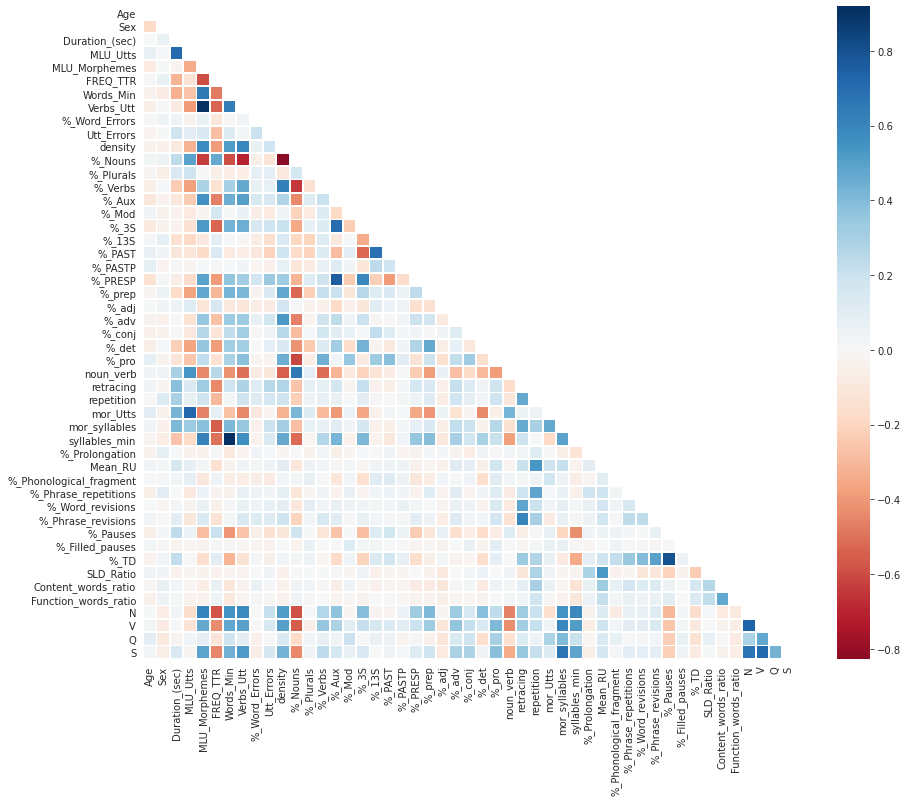

In [9]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,12))
sns.heatmap(df.corr(), 
            annot=False,
            mask = mask,
            cmap = 'RdBu',
            linewidths=.9, 
            linecolor='white',
            fmt='.2g',
            center = 0,
            square=True)

## Classify Probable AD and Control (other categories removed)



In [5]:
df = df[df["Group"] != "MCI"]
df = df[df["Group"] != "Vascular"]
df = df[df["Group"] != "Memory"]
df = df[df["Group"] != "PossibleAD"]
df.Group.value_counts()

ProbableAD    762
Control       243
Name: Group, dtype: int64

In [6]:
X = df.drop(columns = ['Group'])
y = df.Group

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [12]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, plot_confusion_matrix

### Decision Tree

In [13]:
parameters = {'min_samples_split': np.linspace(0, 0.1, 100), 'max_depth': [i for i in range(7, 10)]}
dtc = DecisionTreeClassifier(random_state = 12)

clf1 = GridSearchCV(dtc, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf1.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:    6.9s


Best: 0.890543 using {'max_depth': 9, 'min_samples_split': 0.00505050505050505}


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   13.2s finished


In [14]:
y_pred = clf1.predict(scaled_X_test)

In [15]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

172 Correct out of 201
Accuracy:  0.8557213930348259


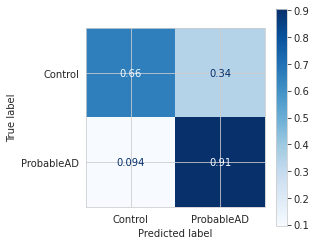

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(clf1, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()

### Random Forest

In [18]:
parameters = {'n_estimators': [i*10 for i in range(20, 26)], 'min_samples_split': np.linspace(0, 0.1, 10), 'max_depth': [i for i in range(5, 10)]}

rfc = RandomForestClassifier(random_state = 12)
clf2 = GridSearchCV(rfc, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf2.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  8.9min finished


Best: 0.936592 using {'max_depth': 8, 'min_samples_split': 0.022222222222222223, 'n_estimators': 240}


In [19]:
y_pred = clf2.predict(scaled_X_test)

In [20]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

173 Correct out of 201
Accuracy:  0.8606965174129353


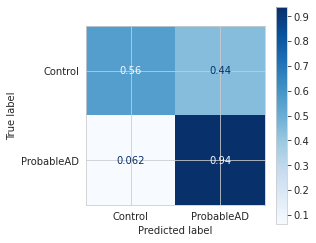

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(clf2, scaled_X_test, y_test, normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()

### XGB Classifier

In [22]:
parameters = {'n_estimators': [i*10 for i in range(5, 11)], 'max_depth': [2*i for i in range(1, 5)], 'colsample_bytree': [0.01*i for i in range(60, 70)]}
xgb = XGBClassifier(seed = 12)
clf3 = GridSearchCV(xgb, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf3.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.9min finished


Best: 0.941553 using {'colsample_bytree': 0.62, 'max_depth': 6, 'n_estimators': 90}


In [ ]:
clf3 = XGBClassifier(colsample_bytree= 0.65, max_depth= 2, n_estimators= 90)
clf3.fit(scaled_X_train, y_train.ravel())

In [23]:
y_pred = clf3.predict(scaled_X_test)

In [24]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

179 Correct out of 201
Accuracy:  0.8905472636815921


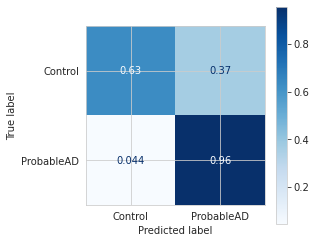

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(clf3, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()

### Support Vector Classifier

In [26]:
parameters = {'C': np.linspace(7, 15, 100), 'kernel': ('poly', 'rbf', 'sigmoid')}
svc = SVC(random_state = 12)
clf4 = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf4.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   16.8s


Best: 0.927888 using {'C': 11.202020202020202, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   22.3s finished


In [27]:
y_pred = clf4.predict(scaled_X_test)

In [28]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

181 Correct out of 201
Accuracy:  0.900497512437811


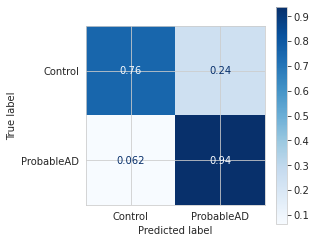

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(clf4, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()